<font size=5>**Project - Autoencoders for MNIST Fashion**</font>

<font size=4>**Importing the Modules**</font>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Set rendom seeds
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set following for matplotlib figures.
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<font size=4>**Preparing the Dataset**</font>

In [4]:
# Load the Train & Test data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
# Scale the X_train_full and X_test data sets with 255.
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [6]:
# Slice the X_train_full for creating the X_valid & X_train
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

In [7]:
# Similarly, slice the y_train_full...
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

<font size=4>**Defining some Utility Functions**</font>

In [8]:
# Define the rounded_accuracy:

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
# Define the plot_image function:

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [10]:
# Define the show_reconstructions:

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

<font size=4>**Building the Autoencoder**</font>

In [11]:
# Define the encoder stacked_encoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

In [12]:
# Similarly, we shall define the encoder stacked_decoder
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [13]:
# We shall now club them to form our complete autoencoder stacked_ae.
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [14]:
# Now, we compile the stacked_ae
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

<font size=4>**Training the Autoencoder**</font>

In [15]:
import time

In [16]:
start = time.time()

In [17]:
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9002
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2986 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [18]:
end = time.time()

In [19]:
# Print the time of execution:
print("Time of execution:", round(end-start,2),"seconds")

Time of execution: 142.38 seconds


<font size=4>**Evaluating the Model Performance**</font>

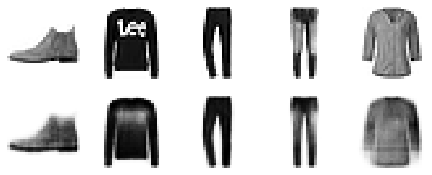

In [20]:
# Use show_reconstructions function
show_reconstructions(stacked_ae, X_test)

In [21]:
# Let us view the rounded_accuracies of X_test
stacked_ae.evaluate(X_test, X_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2845 - rounded_accuracy: 0.9364


[0.28453341126441956, 0.936433732509613]

In [22]:
#  Get the 2D representation of the compressed validation data.
np.random.seed(42)

from sklearn.manifold import TSNE

start = time.time()

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

end = time.time()

print("Time of execution:", round(end-start,2),"seconds")

Time of execution: 43.66 seconds


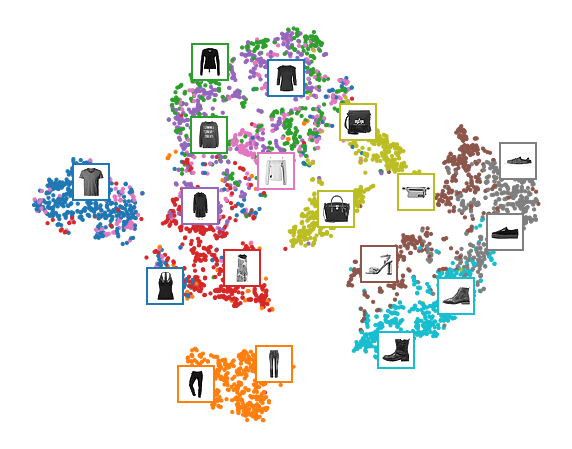

In [23]:
# display the class-wise clusters.
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

<font size=4>**Author:**</font>

- ***Prince Raj***